In [1]:
USERNAME = 'jnahom'
import pandas as pd
from datetime import datetime, timedelta
import forecast_functions
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import numpy as np

In [2]:
#Data
last_ten_alb = pd.read_csv('last_ten_alb.csv')
last_ten_alb

,Unnamed: 0,STNID,NAME,CTRY,COUNTRY_NAME,ISO2C,ISO3C,STATE,LATITUDE,LONGITUDE,...,I_FOG,I_RAIN_DRIZZLE,I_SNOW_ICE,I_HAIL,I_THUNDER,I_TORNADO_FUNNEL,EA,ES,RH,I_PRCP
0,1,725180-14735,ALBANY INTERNATIONAL AIRPORT,US,UNITED STATES,US,USA,NY,42.747,-73.799,...,0,0,0.0,0.0,0.0,0.0,0.6,0.9,67.1,0
1,2,725180-14735,ALBANY INTERNATIONAL AIRPORT,US,UNITED STATES,US,USA,NY,42.747,-73.799,...,1,0,0.0,0.0,0.0,NaN,0.7,0.9,75.4,1
2,3,725180-14735,ALBANY INTERNATIONAL AIRPORT,US,UNITED STATES,US,USA,NY,42.747,-73.799,...,1,0,0.0,0.0,NaN,NaN,0.3,0.5,59.7,1
3,4,725180-14735,ALBANY INTERNATIONAL AIRPORT,US,UNITED STATES,US,USA,NY,42.747,-73.799,...,1,0,0.0,0.0,NaN,NaN,0.3,0.5,67.7,0
4,5,725180-14735,ALBANY INTERNATIONAL AIRPORT,US,UNITED STATES,US,USA,NY,42.747,-73.799,...,0,0,0.0,0.0,0.0,0.0,0.3,0.5,68.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3939,3940,725180-14735,ALBANY INTERNATIONAL AIRPORT,US,UNITED STATES,US,USA,NY,42.747,-73.799,...,1,0,0.0,0.0,0.0,0.0,1.7,2.1,80.5,0
3940,3941,725180-14735,ALBANY INTERNATIONAL AIRPORT,US,UNITED STATES,US,USA,NY,42.747,-73.799,...,0,0,0.0,0.0,0.0,0.0,1.7,1.9,89.1,0
3941,3942,725180-14735,ALBANY INTERNATIONAL AIRPORT,US,UNITED STATES,US,USA,NY,42.747,-73.799,...,1,0,0.0,1.0,0.0,NaN,1.9,2.4,81.9,1
3942,3943,725180-14735,ALBANY INTERNATIONAL AIRPORT,US,UNITED STATES,US,USA,NY,42.747,-73.799,...,1,0,0.0,0.0,0.0,NaN,1.1,1.4,78.1,1


In [3]:
# set YEARMODA (Year-month-day) to datetime format
last_ten_alb['YEARMODA'] = pd.to_datetime(last_ten_alb['YEARMODA'])
print("Most recent date in data:", last_ten_alb['YEARMODA'].max())

Most recent date in data: 2021-10-18 00:00:00


In [4]:
# get date from user to start forecasting
prompt_str = "When should the prediction start? Enter date in YYYY-MM-DD [Enter=tomorrow]: "
prediction_start = input(prompt_str)

When should the prediction start? Enter date in YYYY-MM-DD [Enter=tomorrow]: 2021-10-19


In [5]:
# user hits enter, then just give tomorrow's date
if not prediction_start:
    prediction_start = datetime.today() + timedelta(days=1)
    prediction_start = prediction_start.strftime("%Y-%m-%d")

In [6]:
# establish important dates
prediction_start = datetime.strptime(prediction_start, "%Y-%m-%d")
start_prev_seven = prediction_start - timedelta(days=7)
prediction_start

datetime.datetime(2021, 10, 19, 0, 0)

In [7]:
# create list of dates to submit for forecast evaluation
eval_dates = pd.date_range(prediction_start, periods=7).tolist()

## Precipitation model

In [8]:
prep_pred = ['TEMP','DEWP','SLP','STP','VISIB','WDSP','MXSPD','GUST','MAX','MIN','PRCP']
pred_vars = []
for i in prep_pred:
    last_ten_alb[i+'7'] = last_ten_alb[i].shift(7)
    pred_vars.append(i+'7')
    last_ten_alb[i+'7'] = last_ten_alb[i+'7'].replace(np.nan, 0)
    

In [9]:
last_ten_alb['YEARMODA'] = pd.to_datetime(last_ten_alb['YEARMODA'])
print("Most recent date in data:", last_ten_alb['YEARMODA'].max())

Most recent date in data: 2021-10-18 00:00:00


In [10]:
train, test= np.split(last_ten_alb, [int(.7 *len(last_ten_alb))])

In [11]:
rf = RandomForestClassifier()

rf.fit(train[pred_vars], train['I_PRCP'])

RandomForestClassifier()

              precision    recall  f1-score   support

           0    0.55619   0.73042   0.63151       664
           1    0.42628   0.25577   0.31971       520

    accuracy                        0.52196      1184
   macro avg    0.49124   0.49310   0.47561      1184
weighted avg    0.49914   0.52196   0.49457      1184



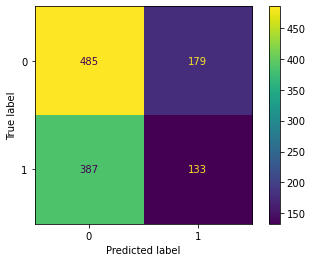

In [12]:
# get predictions
pred_p_prcp = rf.predict_proba(test.loc[:, pred_vars])
pred_i_prcp = rf.predict(test.loc[:, pred_vars])

# evaluation

metrics.plot_confusion_matrix(rf, test.loc[:, pred_vars], test['I_PRCP'])
print(metrics.classification_report(test['I_PRCP'], pred_i_prcp, digits=5))

In [13]:
most_recent_data = last_ten_alb['YEARMODA'].max()
# https://stackoverflow.com/questions/39964558/pandas-max-value-index
most_recent_yday = last_ten_alb.loc[last_ten_alb['YEARMODA'].idxmax(), 'YDAY']
print("Most recent date in data:", last_ten_alb['YEARMODA'].max())


# figure out starting dates for predictions
prediction_start = most_recent_data + timedelta(days=1)
prediction_start_yday = list(most_recent_yday + range(1,8))

# generate list of dates for predictions
eval_dates = pd.date_range(prediction_start, periods=7).tolist()

Most recent date in data: 2021-10-18 00:00:00


In [14]:
eval_dates

[Timestamp('2021-10-19 00:00:00', freq='D'),
 Timestamp('2021-10-20 00:00:00', freq='D'),
 Timestamp('2021-10-21 00:00:00', freq='D'),
 Timestamp('2021-10-22 00:00:00', freq='D'),
 Timestamp('2021-10-23 00:00:00', freq='D'),
 Timestamp('2021-10-24 00:00:00', freq='D'),
 Timestamp('2021-10-25 00:00:00', freq='D')]

In [15]:
predictions_df = pd.DataFrame(eval_dates, columns=['YEARMODA'])
predictions_df['YDAY'] = prediction_start_yday


# add these to the main dataframe
last_ten_alb = last_ten_alb.append(predictions_df, ignore_index=True)

In [16]:
for i in prep_pred:
    last_ten_alb[i+'7'] = last_ten_alb[i].shift(7)
    last_ten_alb[i+'7'] = last_ten_alb[i+'7'].replace(np.nan, 0)

In [17]:
prediction_set = last_ten_alb[(last_ten_alb['YEARMODA'] >= prediction_start)].copy()

In [18]:
prediction_set

,Unnamed: 0,STNID,NAME,CTRY,COUNTRY_NAME,ISO2C,ISO3C,STATE,LATITUDE,LONGITUDE,...,DEWP7,SLP7,STP7,VISIB7,WDSP7,MXSPD7,GUST7,MAX7,MIN7,PRCP7
3944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.9,1019.7,9.2,15.4,0.0,0.0,0.0,15.6,12.0,0.00
3945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.7,1016.5,6.0,12.1,1.0,2.6,0.0,23.3,10.0,0.00
3946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.7,1014.3,3.7,15.6,1.1,4.6,0.0,24.4,12.8,0.00
3947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.7,1013.5,2.9,16.1,0.3,2.1,0.0,18.9,14.4,0.00
3948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.0,1005.8,995.3,13.4,3.9,9.8,17.5,25.0,13.9,23.11
3949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.6,1007.1,996.6,15.4,3.6,8.8,11.3,15.0,8.3,32.26
3950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.5,1009.2,998.5,16.1,3.8,5.7,9.8,11.1,8.3,0.51


In [19]:
prediction_set['P_PRCP'] = rf.predict_proba(prediction_set[pred_vars])[:,1]

In [20]:
prediction_set

,Unnamed: 0,STNID,NAME,CTRY,COUNTRY_NAME,ISO2C,ISO3C,STATE,LATITUDE,LONGITUDE,...,SLP7,STP7,VISIB7,WDSP7,MXSPD7,GUST7,MAX7,MIN7,PRCP7,P_PRCP
3944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1019.7,9.2,15.4,0.0,0.0,0.0,15.6,12.0,0.00,0.46
3945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1016.5,6.0,12.1,1.0,2.6,0.0,23.3,10.0,0.00,0.44
3946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1014.3,3.7,15.6,1.1,4.6,0.0,24.4,12.8,0.00,0.25
3947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1013.5,2.9,16.1,0.3,2.1,0.0,18.9,14.4,0.00,0.38
3948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1005.8,995.3,13.4,3.9,9.8,17.5,25.0,13.9,23.11,0.47
3949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1007.1,996.6,15.4,3.6,8.8,11.3,15.0,8.3,32.26,0.33
3950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1009.2,998.5,16.1,3.8,5.7,9.8,11.1,8.3,0.51,0.40


In [21]:
#%% create training subset
train_dates = []
for i in range(0,12):
    #print(i)
    train_dates_temp = pd.date_range(start_prev_seven - timedelta(days=365*i), periods=7)
    train_dates_temp = train_dates_temp.tolist()
    for j in train_dates_temp:
        train_dates.append(j)

#print(train_dates)
#train_dates = pd.DatetimeIndex(train_dates.values)
print(train_dates)
train_data = last_ten_alb.loc[last_ten_alb['YEARMODA'].isin(train_dates)]

[Timestamp('2021-10-12 00:00:00', freq='D'), Timestamp('2021-10-13 00:00:00', freq='D'), Timestamp('2021-10-14 00:00:00', freq='D'), Timestamp('2021-10-15 00:00:00', freq='D'), Timestamp('2021-10-16 00:00:00', freq='D'), Timestamp('2021-10-17 00:00:00', freq='D'), Timestamp('2021-10-18 00:00:00', freq='D'), Timestamp('2020-10-12 00:00:00', freq='D'), Timestamp('2020-10-13 00:00:00', freq='D'), Timestamp('2020-10-14 00:00:00', freq='D'), Timestamp('2020-10-15 00:00:00', freq='D'), Timestamp('2020-10-16 00:00:00', freq='D'), Timestamp('2020-10-17 00:00:00', freq='D'), Timestamp('2020-10-18 00:00:00', freq='D'), Timestamp('2019-10-13 00:00:00', freq='D'), Timestamp('2019-10-14 00:00:00', freq='D'), Timestamp('2019-10-15 00:00:00', freq='D'), Timestamp('2019-10-16 00:00:00', freq='D'), Timestamp('2019-10-17 00:00:00', freq='D'), Timestamp('2019-10-18 00:00:00', freq='D'), Timestamp('2019-10-19 00:00:00', freq='D'), Timestamp('2018-10-13 00:00:00', freq='D'), Timestamp('2018-10-14 00:00:00'

In [22]:
#%% get average values based on last 7 days
avg_max = train_data['MAX'].mean()
avg_min = train_data['MIN'].mean()

In [23]:
#%% create training subset
max_dict = {}
min_dict = {}

for date in eval_dates:
    train_dates_list = []
    for i in range(0,12):
        #print(i)
        train_dates_temp = date - timedelta(days=365*i)
        train_dates_list.append(train_dates_temp)
    #print(train_dates_temp)
    #print(train_dates)
    #train_dates = pd.DatetimeIndex(train_dates.values)
    #print(train_dates_temp)
    train_data_loop = last_ten_alb.loc[last_ten_alb['YEARMODA'].isin(train_dates_list)]
    #print(train_data_loop)
    avg_max_loop = train_data_loop['MAX'].mean()
    avg_min_loop = train_data_loop['MIN'].mean()
    
    max_dict[date] = avg_max_loop
    min_dict[date] = avg_min_loop
    #print(avg_prcp_loop)
    #print(train_data_loop['MIN'])
    
print(max_dict)
print(min_dict)

{Timestamp('2021-10-19 00:00:00', freq='D'): 17.630000000000003, Timestamp('2021-10-20 00:00:00', freq='D'): 17.95, Timestamp('2021-10-21 00:00:00', freq='D'): 16.9, Timestamp('2021-10-22 00:00:00', freq='D'): 15.23, Timestamp('2021-10-23 00:00:00', freq='D'): 16.46, Timestamp('2021-10-24 00:00:00', freq='D'): 15.439999999999998, Timestamp('2021-10-25 00:00:00', freq='D'): 12.72}
{Timestamp('2021-10-19 00:00:00', freq='D'): 5.760000000000001, Timestamp('2021-10-20 00:00:00', freq='D'): 5.5, Timestamp('2021-10-21 00:00:00', freq='D'): 4.33, Timestamp('2021-10-22 00:00:00', freq='D'): 3.5799999999999996, Timestamp('2021-10-23 00:00:00', freq='D'): 6.55, Timestamp('2021-10-24 00:00:00', freq='D'): 3.8900000000000006, Timestamp('2021-10-25 00:00:00', freq='D'): 2.9099999999999997}


In [24]:
def construct_mean_forecast_df(fc_dates, username, fc_var, avg_val, avg_dict={}):
    """
    Create a dictionary to add to the forecast dataframe.
    This version repeats the average value of a variable
    over the number of days.
    
    This function could be copied and modified to accept
    a list of forecast values instead of a single value
    repeated.
    Parameters
    ----------
    fc_dates : list 
        list of dates in the forecast
    avg_val : float
        Value to repeat across days.
    fc_var : str
        Name of value you are forecasting. Should be 
        one of MAX, MIN, P_PRCP.
    Returns
    -------
    mean_df : pandas.DataFrame()
        Dataframe with column names and list of values for 
        each column.
    """
    
    nrow = len(fc_dates)
    fc_value = []
    
    for i in fc_dates:
        print(i)
        print((avg_val+avg_dict[i])/2)
        fc_value.append((avg_val+avg_dict[i])/2)
        
    mean_dict = {'fc_date': fc_dates, 
              'fc_name': [username] * nrow, 
              'fc_var': [fc_var] * nrow, 
              'fc_value': fc_value}
    #print(mean_dict)
    mean_df = pd.DataFrame.from_dict(mean_dict)
    return mean_df

In [25]:
# format forecasts
fc_max = construct_mean_forecast_df(eval_dates, USERNAME, 'MAX', avg_max, max_dict)
fc_min = construct_mean_forecast_df(eval_dates, USERNAME, 'MIN', avg_min, min_dict)

2021-10-19 00:00:00
18.231883116883118
2021-10-20 00:00:00
18.39188311688312
2021-10-21 00:00:00
17.866883116883116
2021-10-22 00:00:00
17.03188311688312
2021-10-23 00:00:00
17.646883116883117
2021-10-24 00:00:00
17.13688311688312
2021-10-25 00:00:00
15.77688311688312
2021-10-19 00:00:00
6.126753246753246
2021-10-20 00:00:00
5.996753246753246
2021-10-21 00:00:00
5.411753246753246
2021-10-22 00:00:00
5.036753246753246
2021-10-23 00:00:00
6.521753246753246
2021-10-24 00:00:00
5.191753246753247
2021-10-25 00:00:00
4.701753246753246


In [26]:
# Precipitation
fc_prcp = prediction_set[['YEARMODA', 'P_PRCP']]
fc_prcp['fc_name'] = 'jnahom'
fc_prcp['fc_var'] = 'P_PRCP'
fc_prcp.rename(columns={"YEARMODA": "fc_date", "P_PRCP": "fc_value"}, inplace=True)
fc_prcp = fc_prcp[['fc_date', 'fc_name', 'fc_var', 'fc_value']]
fc_prcp

<ipython-input-26-fd81d11341ae>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fc_prcp['fc_name'] = 'jnahom'
<ipython-input-26-fd81d11341ae>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fc_prcp['fc_var'] = 'P_PRCP'
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

,fc_date,fc_name,fc_var,fc_value
3944,2021-10-19,jnahom,P_PRCP,0.46
3945,2021-10-20,jnahom,P_PRCP,0.44
3946,2021-10-21,jnahom,P_PRCP,0.25
3947,2021-10-22,jnahom,P_PRCP,0.38
3948,2021-10-23,jnahom,P_PRCP,0.47
3949,2021-10-24,jnahom,P_PRCP,0.33
3950,2021-10-25,jnahom,P_PRCP,0.40


In [27]:
# define columns
column_names = ['fc_date', 'fc_name', 'fc_var', 'fc_value']
# create empty df
eval_df_base = pd.DataFrame(columns=column_names)

In [28]:
# append forecasts to dataframe
eval_df_base = eval_df_base.append(fc_max, ignore_index=True)
eval_df_base = eval_df_base.append(fc_min, ignore_index=True)
eval_df_base = eval_df_base.append(fc_prcp, ignore_index=True)

In [29]:
#%% save output
outfile_name = USERNAME + '_' + prediction_start.strftime("%Y-%m-%d") + '.csv'
eval_df_base.to_csv(outfile_name, index=False)